## Implementation

In [ ]:
!pip install pgmpy
!pip install networkx
import networkx as nx
from pgmpy.models import BayesianNetwork
import pandas as pd
from IPython.display import Image, display
from pgmpy.estimators import HillClimbSearch, BicScore, PC, K2Score
from pgmpy.estimators import BayesianEstimator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 34.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Structure Learning (DAG)

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


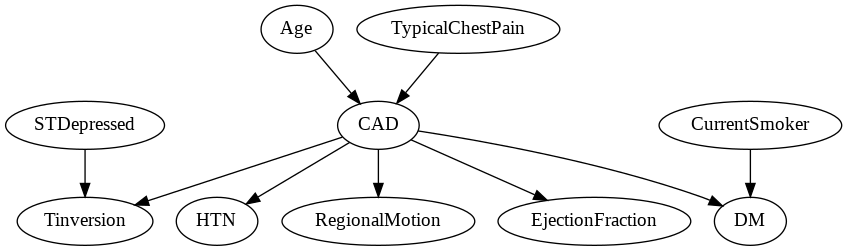

In [ ]:
from pgmpy.models import BayesianModel

# join states
model = BayesianModel([('Age', 'CAD'),   ('TypicalChestPain', 'CAD'),   ('CAD', 'HTN'),
                       ('CAD', 'Tinversion'),  ('CAD', 'RegionalMotion'),   ('CAD', 'DM'),
                       ('CAD', 'EjectionFraction'),  ('STDepressed', 'Tinversion'),  ('CurrentSmoker', 'DM')])
display(Image((nx.drawing.nx_pydot.to_pydot(model)).create_png()))


## Preprocessing values

In [ ]:
from pandas import read_csv, DataFrame
import numpy as np


df_raw = read_csv("./cad_small.csv")

def filter_age(age):
    a = ""
    if age < 53:
        a = "Adult"
    if age >= 53 and age < 64:
        a = "Elder"
    if age >= 64:
        a = "Elderly"
    return a

def filter_ejection(ejec):
    b = ""
    if ejec < 50:
        b = "base"
    else:
        b = "normal"
    return b

df_raw['Age'] = df_raw['Age'].apply(filter_age)
df_raw['EjectionFraction'] = df_raw['EjectionFraction'].apply(filter_ejection)


print("There are " + str(df_raw.shape[0]) + " rows in the dataframe.")
#df_raw['EjectionFraction'].tolist()
#df_raw['Age'].tolist()
df_raw.head()

There are 303 rows in the dataframe.


,Age,DM,HTN,CurrentSmoker,TypicalChestPain,STDepressed,Tinversion,EjectionFraction,RegionalMotion,CAD
0,Elder,0,1,1,0,1,1,normal,0,cad
1,Elderly,0,1,0,1,1,1,base,4,cad
2,Elder,0,0,1,1,0,0,base,2,cad
3,Elderly,0,1,0,0,1,0,normal,0,normal
4,Adult,0,1,0,0,0,0,normal,0,normal


## Building CPT (Conditional Probability Table)

In [ ]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

# hill-climbing algorithm
model.cpds = []
model.fit(data=df_raw, 
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of Age:
+--------------+----------+
| Age(Adult)   | 0.304579 |
+--------------+----------+
| Age(Elder)   | 0.352503 |
+--------------+----------+
| Age(Elderly) | 0.342918 |
+--------------+----------+ 

CPT of CAD:
+------------------+-----+---------------------+
| Age              | ... | Age(Elderly)        |
+------------------+-----+---------------------+
| TypicalChestPain | ... | TypicalChestPain(1) |
+------------------+-----+---------------------+
| CAD(cad)         | ... | 0.9263959390862944  |
+------------------+-----+---------------------+
| CAD(normal)      | ... | 0.07360406091370557 |
+------------------+-----+---------------------+ 

CPT of TypicalChestPain:
+---------------------+----------+
| TypicalChestPain(0) | 0.460064 |
+---------------------+----------+
| TypicalChestPain(1) | 0.539936 |
+---------------------+----------+ 

CPT of HTN:
+--------+--------------------+-------------+
| CAD    | CAD(cad)           | CAD(normal) |
+--------+

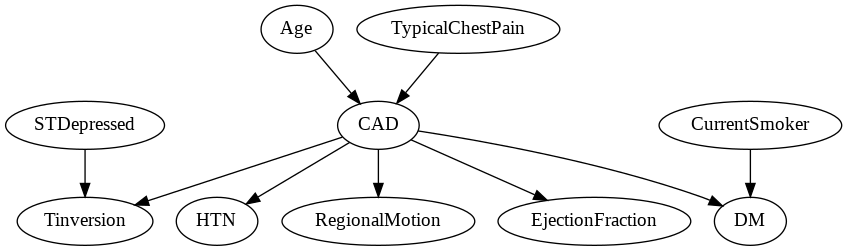

In [ ]:
display(Image((nx.drawing.nx_pydot.to_pydot(model)).create_png()))


In [ ]:
# Initializing the VariableElimination class

from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [ ]:
# Computing the probability of CAD
q = infer.query(variables=['CAD'], evidence={'Age':'Elder'})
print(q)

+-------------+------------+
| CAD         |   phi(CAD) |
+=============+============+
| CAD(cad)    |     0.7199 |
+-------------+------------+
| CAD(normal) |     0.2801 |
+-------------+------------+


/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


In [ ]:

# Computing the joint probability of CAD and DM given AGE='Elder' and typicalchestpain = 1
q = infer.query(variables=['CAD', 'DM'], evidence={'Age': 'Elder','TypicalChestPain':1})
print(q)


+-------------+-------+---------------+
| CAD         | DM    |   phi(CAD,DM) |
+=============+=======+===============+
| CAD(cad)    | DM(0) |        0.6044 |
+-------------+-------+---------------+
| CAD(cad)    | DM(1) |        0.3668 |
+-------------+-------+---------------+
| CAD(normal) | DM(0) |        0.0250 |
+-------------+-------+---------------+
| CAD(normal) | DM(1) |        0.0038 |
+-------------+-------+---------------+


In [ ]:

# Computing the probabilities (not joint) of bronc and asia given AGE='ELder' and typicalchestpain = 1
q = infer.query(variables=['CAD', 'DM'], evidence={'Age': 'Elder','TypicalChestPain':1}, joint=False)
for factor in q.values():
    print(factor)

+-------------+------------+
| CAD         |   phi(CAD) |
+=============+============+
| CAD(cad)    |     0.9712 |
+-------------+------------+
| CAD(normal) |     0.0288 |
+-------------+------------+
+-------+-----------+
| DM    |   phi(DM) |
+=======+===========+
| DM(0) |    0.6294 |
+-------+-----------+
| DM(1) |    0.3706 |
+-------+-----------+


## Inference with mapping

In [ ]:

# Computing the MAP of bronc given 'Age': 'Elderly'.
q = infer.query(variables=['CAD'], evidence={'Age': 'Elderly'})
print("\n",q)




 +-------------+------------+
| CAD         |   phi(CAD) |
+=============+============+
| CAD(cad)    |     0.8406 |
+-------------+------------+
| CAD(normal) |     0.1594 |
+-------------+------------+


In [ ]:
# Computing the MAP of bronc and asia given age='Elderly' and typicalchestpain = 1
q = infer.query(variables=['CAD', 'DM'], evidence={'Age': 'Elderly','TypicalChestPain':1})
print("\n",q)



 +-------------+-------+---------------+
| CAD         | DM    |   phi(CAD,DM) |
+=============+=======+===============+
| CAD(cad)    | DM(0) |        0.5765 |
+-------------+-------+---------------+
| CAD(cad)    | DM(1) |        0.3499 |
+-------------+-------+---------------+
| CAD(normal) | DM(0) |        0.0638 |
+-------------+-------+---------------+
| CAD(normal) | DM(1) |        0.0098 |
+-------------+-------+---------------+


In [ ]:
print(model.get_cpds('CAD'))

+------------------+-----+---------------------+
| Age              | ... | Age(Elderly)        |
+------------------+-----+---------------------+
| TypicalChestPain | ... | TypicalChestPain(1) |
+------------------+-----+---------------------+
| CAD(cad)         | ... | 0.9263959390862944  |
+------------------+-----+---------------------+
| CAD(normal)      | ... | 0.07360406091370557 |
+------------------+-----+---------------------+
